In [87]:
#高値,安値,始値,終値 から 次の時刻の高値を予測する
%matplotlib inline
import chainer
from chainer import optimizers, cuda
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net,MoreLayersNet

In [88]:
n_epoch = 1000000 #エポック
batchsize = 178 #バッチサイズ
bprop_len = 20 #何回でバックプロパゲーションを打ち切るか(truncate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = False #GPUを使うかどうか

In [89]:
xp = cuda.cupy if use_gpu is True else np

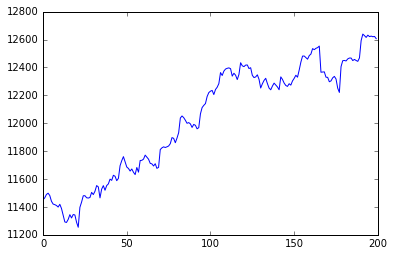

In [90]:
train_data_x = []
train_data_y = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append([row[i] for i in range(1,5)])
    train_data_y.append([row[1]])
train_data_x = np.asarray(train_data_x, dtype=np.float32)
train_data_y = np.asarray(train_data_y, dtype=np.float32)
train_data_x = train_data_x[:-1]
train_data_y = train_data_y[1:]
#plt.plot(train_data_x[:200])
plt.plot(train_data_y[:200])

In [ ]:
#ネットワークを試す関数
def evaluate(model):
    evaluator = model.copy()
    evaluator.reset_state()
    output = []
    for t in train_data_x:
        t = chainer.Variable(xp.array([t],dtype=np.float32))
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [ ]:
model = MoreLayersNet(4, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam(alpha=0.1)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([train_data_x[(jump * j + i) % length] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([train_data_y[(jump * j + i) % length] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 100 == 0:
            print('epoch {}, error {}, alpha{}'.format(epoch, loss_data / length, optimizer.lr))

        loss.append(loss_data / length)
        loss_data = 0
        #model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()
    

epoch 100, error 16323030.016030626, alpha0.045250700233367754
epoch 200, error 15347759.965546118, alpha0.06068194622309896
epoch 300, error 14305433.266180165, alpha0.07057585673555836
epoch 400, error 13542145.01638952, alpha0.07754131952635941
epoch 500, error 12460329.878693623, alpha0.08265764298735262


In [ ]:
plt.plot(loss[0:])

In [ ]:
output = evaluate(model)

In [ ]:
plt.plot(output[0:2000])